In [14]:
from pathlib import Path
from util import NUMBER_REGEX
import numpy as np

from sim import stats
from util import new_load_simulation

simon_dir = "sim/simon_simulations_20220714_continue"
simon_path = Path(simon_dir)

sims = new_load_simulation(simon_path.glob("iopf_sim_DRAG_1*"))

simon_dir = "sim/simon_simulations_20220721_torques"
simon_path = Path(simon_dir)
paths_gen = (i for j in zip(simon_path.glob("iopf_sim_DRAG*"), simon_path.glob("iopf_sim_torque*")) for i in j)

new_load_simulation(paths_gen, dest=sims, prefix="mercurius")

{'iopf_sim_DRAG_1.0_N_100_47220': {'label': 'iopf_sim_DRAG_1.0_N_100_47220',
  'drag_coefficient': 1,
  'n_particles': 100,
  'seed': 47220,
  'path': PosixPath('sim/simon_simulations_20220714_continue/iopf_sim_DRAG_1.0_N_100_47220')},
 'iopf_sim_DRAG_1.0_N_100_61392': {'label': 'iopf_sim_DRAG_1.0_N_100_61392',
  'drag_coefficient': 1,
  'n_particles': 100,
  'seed': 61392,
  'path': PosixPath('sim/simon_simulations_20220714_continue/iopf_sim_DRAG_1.0_N_100_61392')},
 'iopf_sim_DRAG_1.0_N_100_92718': {'label': 'iopf_sim_DRAG_1.0_N_100_92718',
  'drag_coefficient': 1,
  'n_particles': 100,
  'seed': 92718,
  'path': PosixPath('sim/simon_simulations_20220714_continue/iopf_sim_DRAG_1.0_N_100_92718')},
 'iopf_sim_DRAG_1.0_N_100_29381': {'label': 'iopf_sim_DRAG_1.0_N_100_29381',
  'drag_coefficient': 1,
  'n_particles': 100,
  'seed': 29381,
  'path': PosixPath('sim/simon_simulations_20220714_continue/iopf_sim_DRAG_1.0_N_100_29381')},
 'mercuriusiopf_sim_DRAG_1.0_N_100_29381': {'label': 'me

In [17]:
from IPython.display import display
from ipywidgets import interactive, IntSlider, Dropdown, Layout, HTML, HBox, Button
from ctypes import pointer
from math import ceil
import rebound

def open_rebound_sa(sim_data):
    if "mercurius" in sim_data["label"]:
        return rebound.SimulationArchive(str(sim_data["path"] / f"mercurius_rebound_archive.bin"))
    else:
        return rebound.SimulationArchive(str(sim_data["path"] / f"rebound_archive.bin"))

for sim_data in sims.values():
    if "sa" not in sim_data or not sim_data["sa"]:
        sim_data["sa"] = open_rebound_sa(sim_data)

init_sim = rebound.Simulation()
w = init_sim.getWidget(size=(500, 500), scale=0.25)

s = sorted(sims.keys(), key=lambda k: int(k.split("_")[-1]))
archive_dropdown = Dropdown(options=s, value=s[0])
time_slider = IntSlider(min=50000, max=1000000, step=1000, value=100000, layout=Layout(width="600px"))
part_list = HTML(value="<pre>10 most massive:</pre>")

import importlib
importlib.reload(stats)

def update_widget(archive_label, time=0):
    sim_data = sims[archive_label]
    if "sa" not in sim_data or not sim_data["sa"]:
        sim_data["sa"] = open_rebound_sa(sim_data)

    reb_sim_archive = sim_data["sa"]
    time_slider.max = ceil(reb_sim_archive.tmax)
    time_slider.min = ceil(reb_sim_archive.tmin)

    sim = reb_sim_archive.getSimulation(time)
    sim.visualization = 2
    simp = pointer(sim)
    rebound.clibrebound.reb_display_init_data(simp)

    refresh_all(sim_data, simp)

def refresh_all(sim_data, simp):
    sim = simp.contents

    m, a, e, i, P = stats.pprops(sim)
    a_avg = np.average(a, weights=m)
    a_std = np.sqrt(np.average((a-a_avg)**2, weights=m))

    buf = ""
    top10 = np.argsort(m)[-1:-11:-1]
    for j in top10:
        buf += f"m = {m[j]/3e-6:.5f}, a = {a[j]:.5f}, e = {e[j]:.5f}, i = {i[j]:.5f}\n"

    w.useroverlay = f"{'DRAG' if sim_data['drag_coefficient'] else 'NODRAG'}, seed={sim_data['seed']}, ā={a_avg:.3f}, σ_a={a_std:.3f}, e_rms={np.sqrt(np.mean(e**2.)):.3f}, i_rms={np.sqrt(np.mean(i**2.)):.3f}"
    w.simp = simp
    w.refresh(simp)
    part_list.value = f"<pre>{w.overlay}\n10 most massive (top 10: {np.sum(m[top10]/3e-6):.2f}; top 2: {np.sum(m[top10[:2]]/3e-6):.2f}):\n{buf}</pre>"

ws = interactive(update_widget, archive_label=archive_dropdown, time=time_slider)
update_widget(archive_dropdown.value, time_slider.value)

display(archive_dropdown)
display(time_slider)
display(HBox([w, part_list]))

Dropdown(description='archive_label', options=('iopf_sim_DRAG_1.0_N_100_29381', 'mercuriusiopf_sim_DRAG_1.0_N_…

IntSlider(value=100000, description='time', layout=Layout(width='600px'), max=3500000, step=1000)

Text(0, 0.5, 'Drag + Migration Torque')

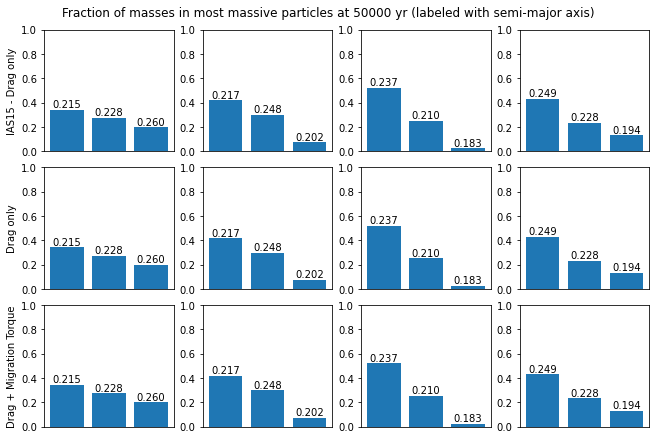

In [18]:
import matplotlib.pyplot as plt

seeds = sorted({sim_data["seed"] for sim_data in sims.values()})
seed_to_column = { seed: i for i, seed in enumerate(seeds) }

fig, axs = plt.subplots(nrows=3, ncols=len(seeds), figsize=(9, 6), constrained_layout=True)
for sim_data in sims.values():
    col = seed_to_column[sim_data["seed"]]
    label = sim_data["label"]
    if "mercurius" not in label:
        row = 0
    elif "torque" in label:
        row = 2
    else:
        row = 1

    ax = axs[row, col]
    sim = sim_data["sa"].getSimulation(50000)

    m, a = np.array([(p.m / 3e-6, p.a) for p in sim.particles[1:]]).T
    idx = np.argsort(m)[-1:-4:-1]

    bars = ax.bar([0, 1, 2], m[idx])
    ax.bar_label(bars, labels=[f"{_a:.3f}" for _a in a[idx]])
    ax.set_ylim(0, 1.0)
    ax.set_xticks([])

fig.suptitle("Fraction of masses in most massive particles at 50000 yr (labeled with semi-major axis)")
axs[0, 0].set_ylabel("IAS15 - Drag only")
axs[1, 0].set_ylabel("Drag only")
axs[2, 0].set_ylabel("Drag + Migration Torque")

Text(0, 0.5, 'Drag + Migration Torque')

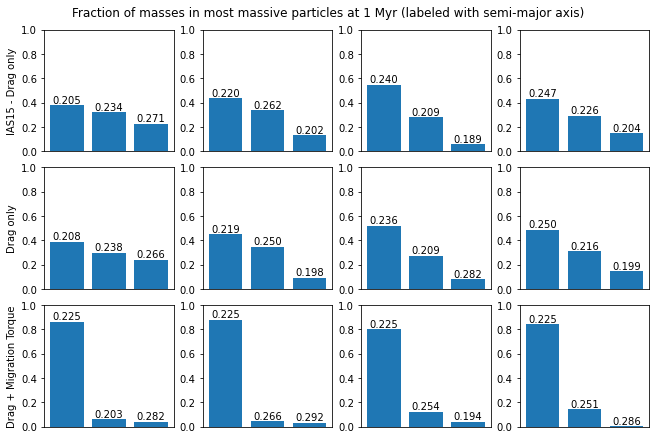

In [19]:
import matplotlib.pyplot as plt

seeds = sorted({sim_data["seed"] for sim_data in sims.values()})
seed_to_column = { seed: i for i, seed in enumerate(seeds) }

fig, axs = plt.subplots(nrows=3, ncols=len(seeds), figsize=(9, 6), constrained_layout=True)
for sim_data in sims.values():
    col = seed_to_column[sim_data["seed"]]
    label = sim_data["label"]
    if "mercurius" not in label:
        row = 0
    elif "torque" in label:
        row = 2
    else:
        row = 1

    ax = axs[row, col]
    sim = sim_data["sa"].getSimulation(1000000)

    m, a = np.array([(p.m / 3e-6, p.a) for p in sim.particles[1:]]).T
    idx = np.argsort(m)[-1:-4:-1]

    bars = ax.bar([0, 1, 2], m[idx])
    ax.bar_label(bars, labels=[f"{_a:.3f}" for _a in a[idx]])
    ax.set_ylim(0, 1.0)
    ax.set_xticks([])

fig.suptitle("Fraction of masses in most massive particles at 1 Myr (labeled with semi-major axis)")
axs[0, 0].set_ylabel("IAS15 - Drag only")
axs[1, 0].set_ylabel("Drag only")
axs[2, 0].set_ylabel("Drag + Migration Torque")

In [42]:
from sim import rebforces

gas_profile_root = Path("disk/calculated_profiles/")
gas_profile_name = "20220721"
gas_profile = np.load(gas_profile_root / gas_profile_name / "all_variables.npz")

rebforces.set_profiles(
    len(gas_profile["r"]),
    gas_profile["r"],
    gas_profile["velocity"].T * rebforces.CM_PER_S,
    gas_profile["rho_0"] * rebforces.G_PER_CM3,
    1.0
)

rebforces.copy_np_to_c(gas_profile["sigma"] * rebforces.G_PER_CM3 / 14959787070000, rebforces.SURFACE_DENSITY_PROF, rebforces.STD_PROF_N.value)
rebforces.copy_np_to_c(gas_profile["H"] / gas_profile["r_cm"], rebforces.SCALE_HEIGHT_PROF, rebforces.STD_PROF_N.value)
rebforces.copy_np_to_c(gas_profile["torque"], rebforces.TORQUE_PROF, rebforces.STD_PROF_N.value)

In [43]:
# sim = w.simp.contents
# sim.G = 4 * np.pi ** 2

sim = rebound.Simulation()
sim.G = 4 * np.pi ** 2

primary = rebound.Particle(m=1.)
sim.add(primary)

rho_p = 3.0 * rebforces.G_PER_CM3.value
r = (3e-6 * 3 / (rho_p * 4 * np.pi))**(1./3)
sim.add(rebound.Particle(simulation=sim, primary=primary, m=3e-6, r=3 / (4 * np.pi), a=0.28, e=0.02, inc=0.01))
sim.move_to_com()

sim.integrator = 'mercurius'

sim.dt = 0.001

sim.ri_mercurius.safe_mode = False

sim.ri_ias15.min_dt = 0

sim.ri_whfast.safe_mode = False
sim.ri_whfast.coordinates = "democraticheliocentric"

sim.collision = 'direct'
sim.collision_resolve = 'merge'

sim.additional_forces = rebforces.IOPF_drag_torque_all
sim.force_is_velocity_dependent = 1

In [53]:
import itertools

for t in itertools.count(sim.t, 100.0):
    try:
        sim.integrate(t)
    except rebound.Collision:
        pass
    sim.move_to_com()
    sim.integrator_synchronize()
    refresh_all(fake_sim_data, w.simp)

KeyboardInterrupt: 

In [ ]:
importlib.reload(rebound)

images_root = Path("images/webgl/")

def save_screenshots(archive_label=None):
    if archive_label is None:
        archive_label = archive_dropdown.value

    sim_data = sims[archive_label]
    if "sa" not in sim_data or not sim_data["sa"]:
        sim_data["sa"] = open_rebound_sa(sim_data)

    reb_sim_archive = sim_data["sa"]
    times = [0, *range(0, 10000, 1000), *range(10000, 100000, 10000), *range(100000, 1000000, 100000), *range(1000000, ceil(reb_sim_archive.tmax) + 1, 250000)]

    image_dir = images_root / archive_label
    image_dir.mkdir(parents=True, exist_ok=True)
    w.useroverlay = f"{'DRAG' if sim_data['drag_coefficient'] else 'NODRAG'}, seed={sim_data['seed']}"
    w.takeScreenshot(times, prefix=str(image_dir / "screenshot"), resetCounter=True, archive=reb_sim_archive)

In [ ]:
# save_screenshots('iopf_sim_DRAG_0.0_N_100_47220')
# save_screenshots('iopf_sim_DRAG_0.0_N_100_61392')
# save_screenshots('iopf_sim_DRAG_1.0_N_100_47220')
# save_screenshots('iopf_sim_DRAG_1.0_N_100_61392')
# save_screenshots('iopf_sim_DRAG_0.0_N_100_92718')
save_screenshots('iopf_sim_DRAG_1.0_N_100_92718')
# save_screenshots('iopf_sim_DRAG_0.0_N_100_29381')
# save_screenshots('iopf_sim_DRAG_1.0_N_100_29381')

In [ ]:
rebound.